In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.interpolate
import scipy.integrate
from termcolor import colored


def main_function(p, m, c0, ro, pl, kr, alpha_x, L, g, s0, kp):
    prop = scipy.integrate.ode(lambda t, s: motion_ode(t, s, alpha_x, p, m, c0, ro, pl, g, kr, kp))
    prop.set_initial_value(s0, 0)
    prop.set_integrator('dopri5', nsteps=1e5)
    lst = []
    prop.set_solout(lambda t, s: stopLength(t, s, L, lst))
    prop.integrate(1e10)
    arr = np.asarray(lst)
    for i in range(arr.shape[0]):
        arr[i][0] = arr[i][0] / 1000
        arr[i][1] = arr[i][1] * 3.6
        arr[i][2] = arr[i][2] / 3600
    max = arr[0][1]
    V_mean = L/(1000*arr[-1, 2])
    litr = p * arr[-1, 2] / (10000*0.4)
    time = arr[-1, 2]
    for i in range(1, arr.shape[0]):
        if arr[i][2] > 0.016:
            min = arr[i][1]
            break
    for j in range(i, arr.shape[0]):
        if min > arr[j][1]:
            min = arr[j][1]
    for i in range(1, arr.shape[0]):
        if max < arr[i][1]:
            max = arr[i][1]
    print("Расстояния пройдено: "+str(L/1000)+" км")
    print("Максимальная скорость: "+str(max)+" км/ч")
    print("Минимальная скорость: "+str(min)+" км/ч")
    print("Средняя скорость: "+str(V_mean)+" км/ч")
    print("Затрачено топлива: "+str(litr)+" л")
    print("Затрачено времени: "+str(time)+" ч")
    return arr


def motion_ode(t, s, alpha_x, p, m, c0, ro, pl, g, kr, kp):
    x, v = s
    a = (p*kp)/(v*m)-c0*ro*(v ** 2)*pl/(2*m)-g*(math.sin(math.atan(alpha_x(x))))-kr*(math.cos(math.atan(alpha_x(x))))
    return [v, a]


def stopLength(t, s, L, lst):
    lst.append(np.hstack((s, t)))
    if (s[0] >= L):
        return -1
    return 0

Введите тип ТС
1-Легковой автомобиль
2-Грузовой автомобиль
3-Велосипедист
2
Грузовой автомобиль: 
При -10 градусах: 
Расстояния пройдено: 198.12994113236851 км
Максимальная скорость: 193.00067509832115 км/ч
Минимальная скорость: 38.59541189911178 км/ч
Средняя скорость: 123.78857778511927 км/ч
Затрачено топлива: 73.57533218645169 л
Затрачено времени: 1.6005510740764475 ч
При +10 градусах: 
Расстояния пройдено: 198.12994113236851 км
Максимальная скорость: 195.46171304604644 км/ч
Минимальная скорость: 38.828008119745704 км/ч
Средняя скорость: 126.41677625329781 км/ч
Затрачено топлива: 72.04570470282793 л
Затрачено времени: 1.567275697138337 ч
При +30 градусах: 
Расстояния пройдено: 198.12994113236851 км
Максимальная скорость: 197.3376085959245 км/ч
Минимальная скорость: 39.065852078361665 км/ч
Средняя скорость: 128.93507976474726 км/ч
Затрачено топлива: 70.63853955065197 л
Затрачено времени: 1.536664354602898 ч


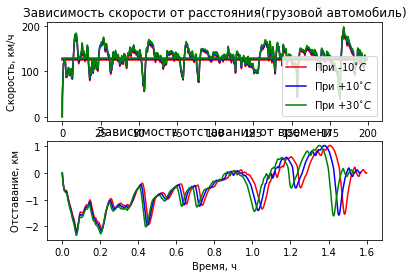

In [3]:
data = np.genfromtxt('example.csv', delimiter=',', names=True)
data1 = np.zeros((data.shape[0], 2))
rad = 6372795
for i in reversed(range(data.shape[0])):
    llat1 = data[i][0]
    llong1 = data[i][1]
    llat2 = data[i-1][0]
    llong2 = data[i-1][1]
    lat1 = llat1 * math.pi / 180.
    lat2 = llat2 * math.pi / 180.
    long1 = llong1 * math.pi / 180.
    long2 = llong2 * math.pi / 180.
    # косинусы и синусы широт и разницы долгот
    cl1 = math.cos(lat1)
    cl2 = math.cos(lat2)
    sl1 = math.sin(lat1)
    sl2 = math.sin(lat2)
    delta = long2 - long1
    cdelta = math.cos(delta)
    sdelta = math.sin(delta)
    # вычисления длины большого круга
    y = math.sqrt(math.pow(cl2 * sdelta, 2) + math.pow(cl1 * sl2 - sl1 * cl2 * cdelta, 2))
    x = sl1 * sl2 + cl1 * cl2 * cdelta
    ad = math.atan2(y, x)
    dist = ad * rad
    data1[i][0] = dist
    data1[i][1] = data[i][2]
data1[0][0] = 0
data1[0][1] = data[0][2]
data2 = np.zeros(data1.shape[0])
for i in range(data.shape[0]):
    data2[i] = data1[i][0]
data2 = np.cumsum(data2)
for i in range(data.shape[0]):
    data1[i][0] = data2[i]
h_x = scipy.interpolate.InterpolatedUnivariateSpline(data1[:, 0], data1[:, 1], k=3)
alpha_x = h_x.derivative(n=1)
L = data1[data1.shape[0]-1][0]
g = 10
kp1 = 0.8;kp2 = 0.6; kp3 = 0.98
s0 = (0, 1e-16)
m_1 = 1500;m_2 = 10000;m_3 = 100
pl_1 = 2.5;pl_2 = 5;pl_3 = 1
c0_1 = 0.25;c0_2 = 0.5;c0_3 = 0.2
p_1 = 735.5*125;p_2 = 735.5*250;p_3 = 200
kr_1 = 0.05;kr_2 = 0.1;kr_3 = 0.005
ro_w = 1.3413;ro_spr = 1.2466;ro_s1 = 1.1644;ro_s2 = 1.1839
print("Введите тип ТС\n1-Легковой автомобиль\n2-Грузовой автомобиль\n3-Велосипедист")
a = int(input())
if a == 1:
    print(colored("Легковой автомобиль: ", 'red'))
    print(colored("При -10 градусах: ", 'blue'))
    arr1 = main_function(p_1, m_1, c0_1, ro_w, pl_1, kr_1, alpha_x, L, g, s0, kp1)
    print(colored("При +10 градусах: ", 'blue'))
    arr2 = main_function(p_1, m_1, c0_1, ro_spr, pl_1, kr_1, alpha_x, L, g, s0, kp1)
    print(colored("При +30 градусах: ", 'blue'))
    arr3 = main_function(p_1, m_1, c0_1, ro_s1, pl_1, kr_1, alpha_x, L, g, s0, kp1)
    fig, ax = plt.subplots(2, 1)
    ax[0].plot(arr1[:, 0], arr1[:, 1], color="red", label="При -10$^{\circ}C$")
    ax[0].plot(range(200), (arr1[-1, 0]/arr1[-1, 2]) * np.ones((200, 1)), color="red")
    ax[0].plot(arr2[:, 0], arr2[:, 1], color="blue", label="При +10$^{\circ}C$")
    ax[0].plot(range(200), (arr2[-1, 0] / arr2[-1, 2]) * np.ones((200, 1)), color="blue")
    ax[0].plot(arr3[:, 0], arr3[:, 1], color="green", label="При +30$^{\circ}C$")
    ax[0].plot(range(200), (arr3[-1, 0] / arr3[-1, 2]) * np.ones((200, 1)), color="green")
    ax[0].legend(loc=0)
    ax[0].set_xlabel('Расстояние, км')
    ax[0].set_ylabel('Скорость, км/ч')
    ax[0].set_title('Зависимость скорости от расстояния(легковой автомобиль)')

    ax[1].plot(arr1[:, 2], arr1[:, 0] - (arr1[-1, 0]/arr1[-1, 2]) * arr1[:, 2], color="red", label="При -10$^{\circ}C$")
    ax[1].plot(arr2[:, 2], arr2[:, 0] - (arr2[-1, 0] / arr2[-1, 2]) * arr2[:, 2], color="blue", label="При +10$^{\circ}C$")
    ax[1].plot(arr3[:, 2], arr3[:, 0] - (arr3[-1, 0] / arr3[-1, 2]) * arr3[:, 2], color="green", label="При +30$^{\circ}C$")
    ax[1].set_xlabel('Время, ч')
    ax[1].set_ylabel('Отставание, км')
    ax[1].set_title('Зависимость отставания от времени')
    plt.show()
elif a == 2:
    print(colored("Грузовой автомобиль: ", 'red'))
    print(colored("При -10 градусах: ", 'blue'))
    arr1 = main_function(p_2, m_2, c0_2, ro_w, pl_2, kr_2, alpha_x, L, g, s0, kp2)
    print(colored("При +10 градусах: ", 'blue'))
    arr2 = main_function(p_2, m_2, c0_2, ro_spr, pl_2, kr_2, alpha_x, L, g, s0, kp2)
    print(colored("При +30 градусах: ", 'blue'))
    arr3 = main_function(p_2, m_2, c0_2, ro_s1, pl_2, kr_2, alpha_x, L, g, s0, kp2)
    fig, ax = plt.subplots(2, 1)
    ax[0].plot(arr1[:, 0], arr1[:, 1], color="red", label="При -10$^{\circ}C$")
    ax[0].plot(range(200), (arr1[-1, 0] / arr1[-1, 2]) * np.ones((200, 1)), color="red")
    ax[0].plot(arr2[:, 0], arr2[:, 1], color="blue", label="При +10$^{\circ}C$")
    ax[0].plot(range(200), (arr2[-1, 0] / arr2[-1, 2]) * np.ones((200, 1)), color="blue")
    ax[0].plot(arr3[:, 0], arr3[:, 1], color="green", label="При +30$^{\circ}C$")
    ax[0].plot(range(200), (arr3[-1, 0] / arr3[-1, 2]) * np.ones((200, 1)), color="green")
    ax[0].legend(loc=0)
    ax[0].set_xlabel('Расстояние, км')
    ax[0].set_ylabel('Скорость, км/ч')
    ax[0].set_title('Зависимость скорости от расстояния(грузовой автомобиль)')

    ax[1].plot(arr1[:, 2], arr1[:, 0] - (arr1[-1, 0] / arr1[-1, 2]) * arr1[:, 2], color="red", label="При -10$^{\circ}C$")
    ax[1].plot(arr2[:, 2], arr2[:, 0] - (arr2[-1, 0] / arr2[-1, 2]) * arr2[:, 2], color="blue", label="При +10$^{\circ}C$")
    ax[1].plot(arr3[:, 2], arr3[:, 0] - (arr3[-1, 0] / arr3[-1, 2]) * arr3[:, 2], color="green", label="При +30$^{\circ}C$")
    ax[1].set_xlabel('Время, ч')
    ax[1].set_ylabel('Отставание, км')
    ax[1].set_title('Зависимость отставания от времени')
    plt.show()
elif a == 3:
    print(colored("Велосипед: ", 'red'))
    print(colored("При +10 градусах: ", 'blue'))
    arr1 = main_function(p_3, m_3, c0_3, ro_spr, pl_3, kr_3, alpha_x, L, g, s0, kp3)
    print(colored("При +25 градусах: ", 'blue'))
    arr2 = main_function(p_3, m_3, c0_3, ro_s2, pl_3, kr_3, alpha_x, L, g, s0, kp3)
    fig, ax = plt.subplots(2, 1)
    ax[0].plot(arr1[:, 0], arr1[:, 1], color="red", label="При +10$^{\circ}C$")
    ax[0].plot(range(200), (arr1[-1, 0] / arr1[-1, 2]) * np.ones((200, 1)), color="red")
    ax[0].plot(arr2[:, 0], arr2[:, 1], color="blue", label="При +25$^{\circ}C$")
    ax[0].plot(range(200), (arr2[-1, 0] / arr2[-1, 2]) * np.ones((200, 1)), color="blue")
    ax[0].legend(loc=0)
    ax[0].set_xlabel('Расстояние, км')
    ax[0].set_ylabel('Скорость, км/ч')
    ax[0].set_title('Зависимость скорости от расстояния(велосипед)')

    ax[1].plot(arr1[:, 2], arr1[:, 0] - (arr1[-1, 0] / arr1[-1, 2]) * arr1[:, 2], color="red", label="При +10")
    ax[1].plot(arr2[:, 2], arr2[:, 0] - (arr2[-1, 0] / arr2[-1, 2]) * arr2[:, 2], color="blue", label="При +25")
    ax[1].set_xlabel('Время, ч')
    ax[1].set_ylabel('Отставание, км')
    ax[1].set_title('Зависимость отставания от времени')
    plt.show()
else:
    print("Неправильный ввод")
    exit(0)